In [24]:
'''coding envrionment Python 3.5'''
## common packages
import os, sys, importlib
# from __future__ import division # if you want to use python 2.x
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## machine learning packages
from sklearn.ensemble import GradientBoostingClassifier #GBC algorithm
from sklearn import linear_model, cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

## in-house library
import Ensemble_library as ES
from Ensemble_tuned_parameters import *
ES = importlib.reload(ES)

In [3]:
## read the data
vectors = pd.read_csv(adj_file,index_col=0)
#print(vectors.head())

# filter out the Nan's and take/not to take the middle ROEs
if drop_middle_thrid:
    vectors_filtered = vectors[vectors['Label']!=2].dropna()
else:
    vectors_filtered = vectors.dropna()

## add 2 more columns of the sign of the change
vectors_filtered['ROE_excess_change_sign'] = vectors_filtered['ROE_excess_change']>0
vectors_filtered['ROE_change_sign'] = vectors_filtered['ROE_change']>0

## check if there is any missing data
assert vectors_filtered.isnull().sum().sum() == 0, "there are some na's in df vectors_filtered"

## how big is our super cleaned data
print(vectors_filtered.shape)
m = len(vectors_filtered)

colnames = vectors_filtered.columns.values
#colnames

(23005, 339)


In [4]:
## we augment the bm model by 300 features
predictors = np.append(colnames[3:303], predictors_bm)

## shuffle the data and take out 10% of data
np.random.seed(seed)
vectors_filtered_shuffled = vectors_filtered.iloc[np.random.permutation(len(vectors_filtered))].reset_index(drop=True)

test_data = vectors_filtered_shuffled.iloc[:int(m*test_portion)]
train_valid_data = vectors_filtered_shuffled.iloc[int(m*test_portion):]

## check if we slice correctly
assert len(test_data)+ len(train_valid_data) == m 

In [5]:
# we want to make sure the % of +'s and -'s are close
# otherwise we need to rebalance
(vectors_filtered_shuffled[y]>0).sum()/len(vectors_filtered_shuffled)

0.45429254509889155

In [6]:
## First we fit a logistic regression model for the bechmark by tuning
## the hyper parameter C
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gsearch_lr_bm= GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid, cv=5)
gsearch_lr_bm.fit(train_valid_data[predictors_bm],train_valid_data[y])

gsearch_lr_bm.grid_scores_, gsearch_lr_bm.best_params_, gsearch_lr_bm.best_score_

([mean: 0.66047, std: 0.00857, params: {'C': 0.001},
  mean: 0.66878, std: 0.00581, params: {'C': 0.01},
  mean: 0.66501, std: 0.00509, params: {'C': 0.1},
  mean: 0.66501, std: 0.00517, params: {'C': 1},
  mean: 0.66496, std: 0.00521, params: {'C': 10},
  mean: 0.66501, std: 0.00531, params: {'C': 100},
  mean: 0.66501, std: 0.00531, params: {'C': 1000}],
 {'C': 0.01},
 0.66877565805361028)

In [7]:
logistic_bm = linear_model.LogisticRegression(penalty='l2', C = gsearch_lr_bm.best_params_["C"])
logistic_bm.fit(train_valid_data[predictors_bm],train_valid_data[y])

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
gbt_bm = GradientBoostingClassifier(**GBT_bm_params)
gbt_bm.fit(train_valid_data[predictors_bm],train_valid_data[y])

GradientBoostingClassifier(init=None, learning_rate=0.026674999999999997,
              loss='deviance', max_depth=5, max_features=9,
              max_leaf_nodes=None, min_samples_leaf=30,
              min_samples_split=1000, min_weight_fraction_leaf=0.0,
              n_estimators=1200, presort='auto', random_state=10,
              subsample=0.85, verbose=0, warm_start=False)


Model Report
Accuracy : 0.7363
AUC Score (Train): 0.820584
CV Score : Mean - 0.7867997 | Std - 0.003241797 | Min - 0.7821996 | Max - 0.7910833


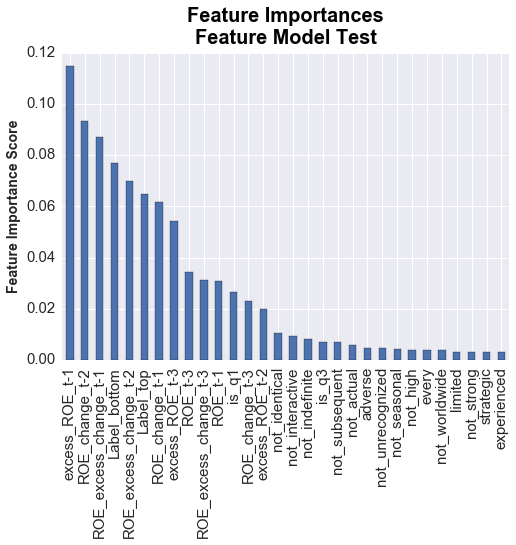

In [9]:
gbt_cv_glimps1 = GradientBoostingClassifier(random_state=10)
ES.modelfit(gbt_cv_glimps1, train_valid_data_transformed, predictors, y, model_name="Feature Model Test")

In [11]:
learning_rate = 0.5335

## this grid search pick n_estimators
min_samples_split = 0.01*len(vectors_filtered) ## make it 1% of the data
param_test1 = {'n_estimators': list(range(20,101,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
    min_samples_split=min_samples_split,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set min_samples_split={}, and tune n_estimators".format(min_samples_split))

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Here we set min_samples_split=230.05, and tune n_estimators


([mean: 0.73279, std: 0.00967, params: {'n_estimators': 20},
  mean: 0.73326, std: 0.00828, params: {'n_estimators': 30},
  mean: 0.73107, std: 0.00603, params: {'n_estimators': 40},
  mean: 0.73085, std: 0.00585, params: {'n_estimators': 50},
  mean: 0.72965, std: 0.00531, params: {'n_estimators': 60},
  mean: 0.72803, std: 0.00543, params: {'n_estimators': 70},
  mean: 0.72675, std: 0.00523, params: {'n_estimators': 80},
  mean: 0.72726, std: 0.00503, params: {'n_estimators': 90},
  mean: 0.72835, std: 0.00413, params: {'n_estimators': 100}],
 {'n_estimators': 30},
 0.73326303893020939)

In [12]:
## this grid search pick max_depth and min_samples_split
n_estimators = gsearch1.best_params_['n_estimators'] ## from previous grid
param_test2 = {'max_depth':list(range(5,16,2)), 'min_samples_split': list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,\
    n_estimators = n_estimators, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set n_estimators={}, and tune max_depth and min_samples_split".format(n_estimators))

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Here we set n_estimators=30, and tune max_depth and min_samples_split


([mean: 0.73317, std: 0.00997, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.73201, std: 0.00837, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.73784, std: 0.00357, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.73870, std: 0.00466, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.74122, std: 0.00545, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.73002, std: 0.00592, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.72954, std: 0.00542, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.73656, std: 0.00835, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.74171, std: 0.00474, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.73846, std: 0.00293, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.72260, std: 0.00607, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.73500, std: 0.00427, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [13]:
## this grid search pick min_samples_split and min_samples_leaf

max_depth = gsearch2.best_params_['max_depth']

param_test3 = {'min_samples_split':list(range(1000,2100,200)), 'min_samples_leaf': list(range(30,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate= learning_rate,\
        n_estimators=n_estimators, max_depth= max_depth,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_valid_data[predictors],train_valid_data[y])


print("Here we set max_depth={}, and tune min_samples_split and min_samples_leaf".format(max_depth))

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_


Here we set max_depth=9, and tune min_samples_split and min_samples_leaf


([mean: 0.73880, std: 0.00691, params: {'min_samples_leaf': 30, 'min_samples_split': 1000},
  mean: 0.74427, std: 0.00712, params: {'min_samples_leaf': 30, 'min_samples_split': 1200},
  mean: 0.74371, std: 0.00368, params: {'min_samples_leaf': 30, 'min_samples_split': 1400},
  mean: 0.74816, std: 0.00446, params: {'min_samples_leaf': 30, 'min_samples_split': 1600},
  mean: 0.73859, std: 0.00427, params: {'min_samples_leaf': 30, 'min_samples_split': 1800},
  mean: 0.73925, std: 0.01029, params: {'min_samples_leaf': 30, 'min_samples_split': 2000},
  mean: 0.74202, std: 0.00723, params: {'min_samples_leaf': 40, 'min_samples_split': 1000},
  mean: 0.74325, std: 0.00662, params: {'min_samples_leaf': 40, 'min_samples_split': 1200},
  mean: 0.74583, std: 0.00638, params: {'min_samples_leaf': 40, 'min_samples_split': 1400},
  mean: 0.74231, std: 0.00434, params: {'min_samples_leaf': 40, 'min_samples_split': 1600},
  mean: 0.74001, std: 0.00316, params: {'min_samples_leaf': 40, 'min_samples_spl

In [14]:
## this grid search pick max_features
min_samples_leaf = gsearch3.best_params_['min_samples_leaf']
min_samples_split = gsearch3.best_params_['min_samples_split']

param_test4 = {'max_features': list(range(7,30,2))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
        n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, subsample=0.8, random_state=10),
        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_valid_data[predictors],train_valid_data[y])


print("Here we set min_samples_leaf={} and min_samples_split={}, and tune max_features"
      .format(min_samples_leaf,min_samples_split))

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Here we set min_samples_leaf=30 and min_samples_split=1600, and tune max_features


([mean: 0.71966, std: 0.00719, params: {'max_features': 7},
  mean: 0.73070, std: 0.01281, params: {'max_features': 9},
  mean: 0.73797, std: 0.00479, params: {'max_features': 11},
  mean: 0.73706, std: 0.00743, params: {'max_features': 13},
  mean: 0.74689, std: 0.00310, params: {'max_features': 15},
  mean: 0.74816, std: 0.00446, params: {'max_features': 17},
  mean: 0.75051, std: 0.00602, params: {'max_features': 19},
  mean: 0.75450, std: 0.00533, params: {'max_features': 21},
  mean: 0.75913, std: 0.00130, params: {'max_features': 23},
  mean: 0.75169, std: 0.00963, params: {'max_features': 25},
  mean: 0.75076, std: 0.00433, params: {'max_features': 27},
  mean: 0.75573, std: 0.00611, params: {'max_features': 29}],
 {'max_features': 23},
 0.75913310277142165)

In [15]:
## this grid search pick subsample

max_features = gsearch4.best_params_['max_features']

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 =  GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=learning_rate,
        n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, max_features = max_features, random_state=10),
        param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_valid_data[predictors],train_valid_data[y])

print("Here we set max_features={}, and tune subsample".format(max_features))

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Here we set max_features=23, and tune subsample


([mean: 0.74520, std: 0.00333, params: {'subsample': 0.6},
  mean: 0.74715, std: 0.00649, params: {'subsample': 0.7},
  mean: 0.74847, std: 0.00440, params: {'subsample': 0.75},
  mean: 0.75913, std: 0.00130, params: {'subsample': 0.8},
  mean: 0.75661, std: 0.00213, params: {'subsample': 0.85},
  mean: 0.75744, std: 0.00601, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.75913310277142165)

In [16]:
subsample = gsearch5.best_params_['subsample']
print('learning_rate =',learning_rate, ', n_estimators =', n_estimators)

learning_rate = 0.5335 , n_estimators = 30



Model Report
Accuracy : 0.8059
AUC Score (Train): 0.893954
CV Score : Mean - 0.7885195 | Std - 0.003890259 | Min - 0.7842067 | Max - 0.7937758


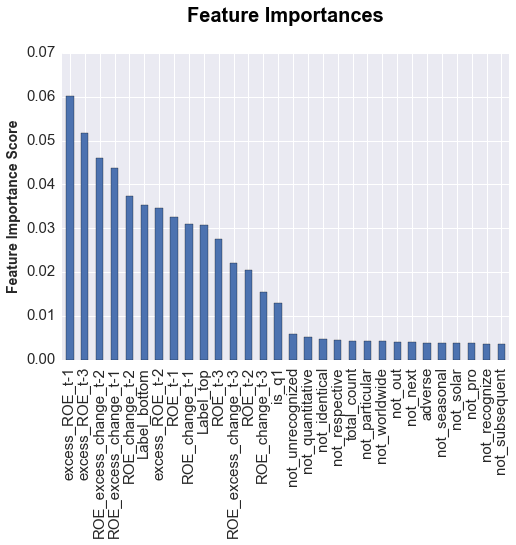

In [17]:
# Now lets reduce to one-twentieth of the original value
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=learning_rate/20, n_estimators=n_estimators*20,
            max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, subsample=subsample, 
            random_state=10, max_features=max_features)

ES.modelfit(gbm_tuned_3, train_valid_data, predictors, y)

In [18]:
gbm_tuned_3.get_params()

{'init': None,
 'learning_rate': 0.026674999999999997,
 'loss': 'deviance',
 'max_depth': 9,
 'max_features': 23,
 'max_leaf_nodes': None,
 'min_samples_leaf': 30,
 'min_samples_split': 1600,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 600,
 'presort': 'auto',
 'random_state': 10,
 'subsample': 0.8,
 'verbose': 0,
 'warm_start': False}

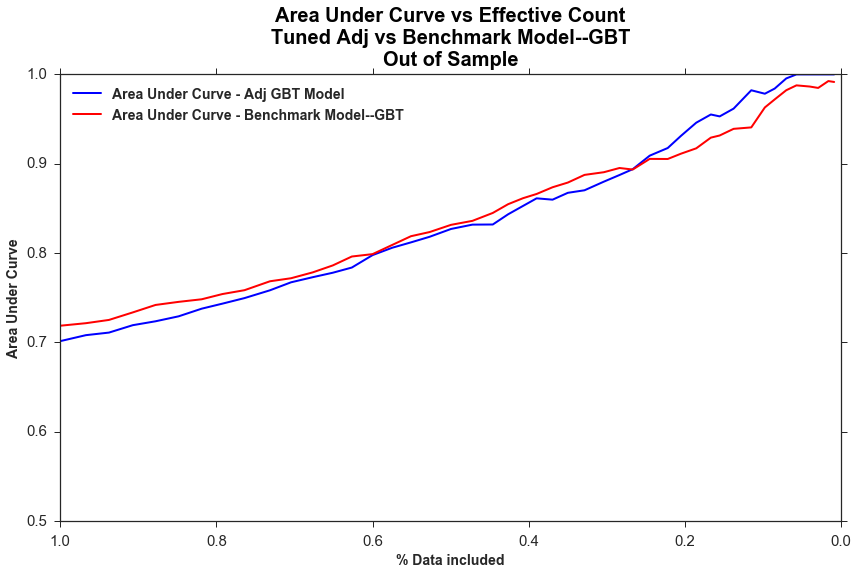

In [25]:
ES.AUCvsCountsPlot(gbm_tuned_3, test_data, predictors, y, 
                       model_name="Adj GBT Model", alg2=gbt_bm, dtest2=test_data,
                       predictors2=predictors_bm, y2=y, model_name2="Benchmark Model--GBT",
                       title_second_line = "Tuned Adj vs Benchmark Model--GBT\nOut of Sample")